# Problem 10.4 - Heat Equation with Markers

In [35]:
# Import necessary packages
using SparseArrays
using StaticArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf

include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")

compute_timestep (generic function with 1 method)

In this example, we prescribe the velocity field with a constant vx=vy=$10^{-9}$ m/s. When markers exit the domain, they should re-enter the other side.

In [76]:
function move_markers_constant_velocity!(markers::Markers,grid::CartesianGrid,vx,vy,dt)
    for i in 1:markers.nmark
        markers.x[1,i] += dt*vx
        markers.x[2,i] += dt*vy
    end
    replace_markers!(markers,grid)
    find_cells!(markers.grid)
end

function replace_markers!(markers::Markers,grid::CartesianGrid)
     for i in 1:markers.nmark
        if markers.x[1,i] > grid.W
            markers.x[1,i] -= grid.W
        end
        if markers.x[2,i] > grid.H
            markers.x[2,i] -= grid.H
        end
    end
end

# Define a function to form the energy equation left hand side and right hand side
function assemble_energy_equation(grid::CartesianGrid,rho,Cp,kThermal,H,Tlast,dt)
    N = grid.nx*grid.ny
    row = zeros(Int64,5*N);
    col = zeros(Int64,5*N);
    val = zeros(Float64, 5*N);
    R = zeros(Float64,N,1);
    k = 1;
    
    for j in 1:grid.nx
        dxc = grid.x[2] - grid.x[1] # uniform spacing for now...
        dxp = dxc;
        dxm = dxc;
        for i in 1:grid.ny
            dyc = grid.y[2] - grid.y[1] # uniform spacing for now...
            dyp = dyc;
            dym = dyc;
            this_row = node_index(i,j,grid.ny);
            # kA, kB, kC, kD
            kA = j==1 ? kThermal[i,j] : 0.5*(kThermal[i,j-1] + kThermal[i,j])
            kB = j==grid.nx ? kThermal[i,j] : 0.5*(kThermal[i,j] + kThermal[i,j+1])
            kC = i==1 ? kThermal[i,j] : 0.5*(kThermal[i-1,j] + kThermal[i,j])
            kD = i==grid.ny ? kThermal[i,j] : 0.5*(kThermal[i,j] + kThermal[i+1,j])
            # diagonal entry
            row[k] = this_row
            col[k] = this_row
            val[k] = (rho[i,j]*Cp[i,j])/dt + kB/dxp/dxc + kA/dxm/dxc + kD/dyp/dyc + kC/dyp/dyc;
            k+=1
            # right
            row[k] = this_row
            col[k] = j==grid.nx ? node_index(i,1,grid.ny) : node_index(i,j+1,grid.ny);
            val[k] = -kB/dxp/dxc;
            k+=1
            # left
            row[k] = this_row
            col[k] = j==1 ? node_index(i,grid.nx,grid.ny) : node_index(i,j-1,grid.ny);
            val[k] = -kA/dxm/dxc;
            k+=1
            # down (+y)
            row[k] = this_row
            col[k] = i==grid.ny ? node_index(1,grid.nx,grid.ny) : node_index(i+1,j,grid.ny);
            val[k] = -kD/dyp/dyc;
            k+=1
            # up (-y)
            row[k] = this_row
            col[k] = i==1 ? node_index(grid.ny,j,grid.ny) : node_index(i-1,j,grid.ny);
            val[k] = -kC/dyp/dyc;
            k+=1
            R[this_row] = Tlast[i,j]*rho[i,j]*Cp[i,j]/dt            
        end
    end
    row = @views row[1:k-1]
    col = @views col[1:k-1]
    val = @views val[1:k-1]
    L = sparse(row,col,val)
    return L,R
end

assemble_energy_equation (generic function with 2 methods)

In [77]:
nx = 21
ny = 31
W = 1e6
H = 1.5e6
markx = 5
marky = 5
seconds_in_year = 3.15e7
plot_interval = 1e5*seconds_in_year # plot interval in seconds
end_time = 30e6*seconds_in_year # end time in seconds
dtmax = plot_interval
grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid ; nmx=markx,nmy=marky,random=false)

Creating Markers...
  0.000295 seconds (12 allocations: 763.312 KiB)


Markers([5000.0 15000.0 … 7.291118556459266e-304 7.291118556459266e-304; 5000.0 5000.0 … 7.291118556459266e-304 7.291118556459266e-304], [1 1 … 72057589759737855 72057589759737855; 1 1 … 72057589759737855 72057589759737855], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304], [7.291118556459266e-304, 2.853175e-318, 6.94953861141147e-310, 7.4294983e-316, 0.0, 0.0, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304  …  7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304, 7.291118556459266e-304], 15000)

In [78]:
# define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
rho = zeros(grid.ny,grid.nx);
kThermal = zeros(grid.ny,grid.nx);
Cp = zeros(grid.ny,grid.nx);
H = zeros(grid.ny,grid.nx); 
fill!(rho,3200.);
fill!(kThermal,3.0);
fill!(Cp,1000.);

Energy Equation:
$$
\rho C_p \frac{\partial T}{\partial t} = \nabla\cdot(k \nabla T) + H
$$

Implicit form:
$$
\rho C_p \frac{T^{n+1}-T^n}{\Delta t} = \nabla\cdot(k \nabla T^{n+1}) + H
$$

$$
\rho C_p \frac{T^{n+1}}{\Delta t} - \nabla\cdot(k \nabla T^{n+1}) =  H + \rho C_p \frac{T^n}{\Delta t} 
$$

In [79]:
# temperature initial condition
T = zeros(grid.ny,grid.nx)
for i in 1:grid.ny
    for j in 1:grid.nx
        if grid.x[j] > 4e5 && grid.x[j] < 6e5 && grid.y[i] > 6e5 && grid.y[i] < 9e5
                T[i,j] = 1300.
        else
            T[i,j] = 1000.
        end
    end
end

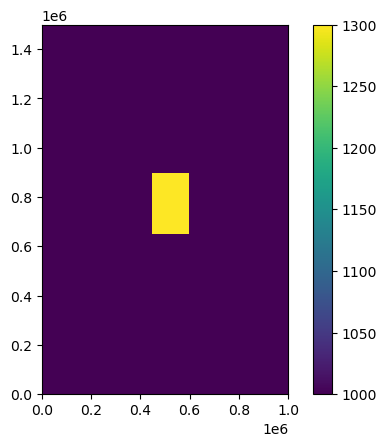

In [80]:
using PyPlot
figure()
pcolor(grid.x,grid.y,T)
colorbar()
gca().set_aspect("equal")
show()

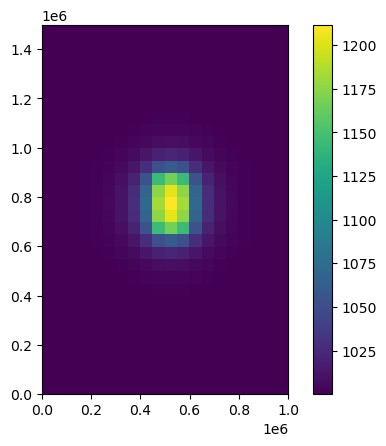

In [91]:
dt = 1e8*3.15e7;
L,R = assemble_energy_equation(grid,rho,Cp,kThermal,H,T,dt)
Tnew = L\R

figure()
pcolor(grid.x,grid.y,reshape(Tnew,grid.ny,grid.nx) )
colorbar()
gca().set_aspect("equal")
show()